In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas
import sunode.wrappers.as_theano as sun


## Generate Data
from scipy.integrate import ode
alpha  = 1
beta=0.1
gamma=1.5
delta=0.75 * 0.1
def dX_dt(t, state,par):
    """ Return the growth rate of fox and rabbit populations. """
    alpha,beta,gamma,delta = par
    return np.array([ alpha*state[0] -   beta*state[0]*state[1],
                  -gamma*state[1] + delta*state[0]*state[1]])

t = np.linspace(0, 24,  50)              # time
X0 = np.array([10, 5])                    # initials conditions: 10 rabbits and 5 foxes
r = ode(dX_dt).set_integrator('dopri5')
r.set_initial_value(X0, t[0])
r.set_f_params((alpha,beta,gamma,delta))
X = np.zeros((len(X0),len(t)))
X[:,0] = X0
for i, _t in enumerate(t):
    if i == 0:
        continue
    r.integrate(_t)
    X[:, i] = r.y

np.random.seed(0)
yobs = X.T * np.random.lognormal(mean=0,sigma=0.1,size=X.T.shape)  #np.maximum(X.T + 2*np.random.randn(*X.T.shape),1)
times = t
print(yobs.std(axis=0))
yobs_norm = yobs / yobs.std(axis=0)



## Do Bayesian Sindy
def predator_prey_sunode_library(t, y, p):
    du_dt = p.pn[0] * y.u + p.pn[2] * y.v + p.pn[4] * y.u * y.v + p.pn[6] * y.u**2 + p.pn[8]* y.v**2 + p.pn[10] - 1e-5 * y.u**3
    dv_dt = p.pn[1] * y.u + p.pn[3] * y.v + p.pn[5] * y.u * y.v + p.pn[7] * y.u**2 + p.pn[9]*y.v**2 + p.pn[11] - 1e-5 * y.v**3
    return {'u': du_dt, 'v' : dv_dt}


d = 12

model_ss = pm.Model()

with model_ss:

    sigma = pm.Lognormal('sigma', mu=-1, sigma=0.1, shape=2)
    pn = pm.Laplace('pn', mu=0, b=1, shape=d)
    xi = pm.Bernoulli('xi', 0.8, shape=d)
    pnss = pm.Deterministic('pnss', pn * xi)
    y0 = pm.Lognormal('y0', mu=pm.math.log(1), sigma=1, shape=2)

    y_hat = sun.solve_ivp(
        y0={
            'u': (y0[0], ()),
            'v': (y0[1], ()),
            },
            params={
                'pn' : (pnss,d),
                'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
            },
            rhs=predator_prey_sunode_library,
    make_solver='BDF',
            tvals=times,
            t0=times[0],
        )[0]

    uobs = pm.Lognormal('uobs', mu=pm.math.log(y_hat['u'][:]), sigma=sigma[0], observed=yobs_norm[:,0])
    vobs = pm.Lognormal('vobs', mu=pm.math.log(y_hat['v'][:]), sigma=sigma[1], observed=yobs_norm[:,1])

with model_ss:

    start = pm.find_MAP()

    # Initialize parameters with least squares and all other values with MAP
    inp = yobs_norm
    u = inp[:,0]
    v = inp[:,1]

    θ = np.array([u,v,u*v,u**2,v**2,np.ones(u.shape)]).T

    import pysindy as ps
    from pysindy.differentiation import SmoothedFiniteDifference
    sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
    dx = sfd(inp)

    guess = np.linalg.lstsq(θ,dx)[0]
    
    print('Initialization')
    print(guess)

    start['pn'] = guess.flatten()
    start['pnss'] = start['pn']
    start['xi'] = np.ones(start['pn'].shape).astype(int)
    start['y0'] = yobs_norm[0,:]
    start['y0_log__'] = np.log(start['y0'])

    
    synthetic_ss_12param = pm.backends.load_trace('../synthetic_ss_12param' + '.trace',model_ss)

[10.94487607  6.80885278]


logp = -150.16, ||grad|| = 20.741: 100%|██████████| 51/51 [00:00<00:00, 173.08it/s]   
/home/hirshs/anaconda3/envs/mars-sunode/lib/python3.7/site-packages/ipykernel_launcher.py:95: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Initialization
[[-0.00799787  0.08987216]
 [-0.75074696 -0.5146038 ]
 [-0.12253869  0.21118045]
 [ 0.050315    0.02684945]
 [ 0.12290753  0.0284561 ]
 [ 0.84539028 -0.19105767]]


In [2]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas
import sunode.wrappers.as_theano as sun


from scipy.integrate import ode
alpha  = 1
beta=0.1
gamma=1.5
delta=0.75 * 0.1
def dX_dt(t, state,par):
    """ Return the growth rate of fox and rabbit populations. """
    alpha,beta,gamma,delta = par
    return np.array([ alpha*state[0] -   beta*state[0]*state[1],
                  -gamma*state[1] + delta*state[0]*state[1]])

t = np.linspace(0, 24,  50)              # time
X0 = np.array([10, 5])                    # initials conditions: 10 rabbits and 5 foxes
r = ode(dX_dt).set_integrator('dopri5')
r.set_initial_value(X0, t[0])
r.set_f_params((alpha,beta,gamma,delta))
X = np.zeros((len(X0),len(t)))
X[:,0] = X0
for i, _t in enumerate(t):
    if i == 0:
        continue
    r.integrate(_t)
    X[:, i] = r.y

np.random.seed(0)
yobs = X.T * np.random.lognormal(mean=0,sigma=0.1,size=X.T.shape)  #np.maximum(X.T + 2*np.random.randn(*X.T.shape),1)
times = t
print(yobs.std(axis=0))
yobs_norm = yobs / yobs.std(axis=0)


slab_df = 4
slab_scale = 2

## Do Bayesian Sindy
def predator_prey_sunode_library(t, y, p):
    du_dt = p.pn[0] * y.u + p.pn[2] * y.v + p.pn[4] * y.u * y.v + p.pn[6] * y.u**2 + p.pn[8]* y.v**2 + p.pn[10] - 1e-5 * y.u**3
    dv_dt = p.pn[1] * y.u + p.pn[3] * y.v + p.pn[5] * y.u * y.v + p.pn[7] * y.u**2 + p.pn[9]*y.v**2 + p.pn[11] - 1e-5 * y.v**3
    return {'u': du_dt, 'v' : dv_dt}

model_rh = pm.Model()

d = 12

with model_rh:

    sigma = pm.Lognormal('sigma', mu=-1, sigma=0.1, shape=2)
    
    l = pm.HalfStudentT('l', nu=1, sigma=1, shape=d)
    tau = pm.HalfStudentT('tau', nu=1, sigma=0.1)
    c2 = pm.InverseGamma('c2', alpha=0.5*slab_df, beta=0.5*slab_df*slab_scale**2)
    
    lt = (pm.math.sqrt(c2)*l) / pm.math.sqrt(c2 + pm.math.sqr(tau) * pm.math.sqr(l))
    
    z  = pm.Normal('z', mu=0, sigma=1, shape=d)
    pn = pm.Deterministic('pn', z*tau*lt)
    #pn = pm.Normal('pn', mu=0, sigma=tau*l, shape=10)
    
    y0 = pm.Lognormal('y0', mu=pm.math.log(1), sigma=1, shape=2)

    y_hat = sun.solve_ivp(
        y0={
            'u': (y0[0], ()),
            'v': (y0[1], ()),
            },
            params={
                'pn' : (pn, d),
                'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
            },
            rhs=predator_prey_sunode_library,
    make_solver='BDF',
            tvals=times,
            t0=times[0],
        )[0]

    uobs = pm.Lognormal('uobs', mu=pm.math.log(y_hat['u'][:]), sigma=sigma[0], observed=yobs_norm[:,0])
    vobs = pm.Lognormal('vobs', mu=pm.math.log(y_hat['v'][:]), sigma=sigma[1], observed=yobs_norm[:,1])
    
    
    #start = pm.find_MAP()

    # Initialize parameters with least squares and all other values with MAP
    inp = yobs_norm
    u = inp[:,0]
    v = inp[:,1]

    θ = np.array([u,v,u*v,u**2,v**2,np.ones(u.shape)]).T

    import pysindy as ps
    from pysindy.differentiation import SmoothedFiniteDifference
    sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
    dx = sfd(inp)

    guess = np.linalg.lstsq(θ,dx)[0]
    
    print('Initialization')
    print(guess)
    
    start = dict()
    start['pn'] = guess.flatten()
    start['tau'] = 0.1
    start['y0'] = yobs_norm[0,:]
    start['y0_log__'] = np.log(start['y0'])
    

    #trace = pm.sample(1000, tune=500, cores=2, random_seed=0, target_accept=0.99, start=start)

    #pm.backends.save_trace(trace,'synthetic_rh_12param' + '.trace',model_sunode)

    synthetic_rh_12param = pm.backends.load_trace('../synthetic_rh_12param_long' + '.trace',model_rh)

[10.94487607  6.80885278]
Initialization
[[-0.00799787  0.08987216]
 [-0.75074696 -0.5146038 ]
 [-0.12253869  0.21118045]
 [ 0.050315    0.02684945]
 [ 0.12290753  0.0284561 ]
 [ 0.84539028 -0.19105767]]


/home/hirshs/anaconda3/envs/mars-sunode/lib/python3.7/site-packages/ipykernel_launcher.py:102: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [3]:
# plot mean and intervals
with model_ss:
    ppc_ss = pm.sample_posterior_predictive(synthetic_ss_12param, var_names=['uobs','vobs','sigma'], random_seed=2)



100%|██████████| 8000/8000 [00:40<00:00, 199.09it/s]


In [4]:
# plot mean and intervals
with model_rh:
    ppc_rh = pm.sample_posterior_predictive(synthetic_rh_12param, var_names=['uobs','vobs'], random_seed=2)



100%|██████████| 4000/4000 [00:21<00:00, 184.41it/s]


In [5]:
synthetic_ss_12param['xi'].mean(axis=0).reshape(2,6,order='F')

array([[0.995   , 0.274   , 1.      , 0.090875, 0.192875, 0.357375],
       [0.1275  , 1.      , 1.      , 0.011875, 0.031375, 0.172625]])

In [8]:
'''# create some data
n = 1000
exps = (synthetic_ss_12param['pnss'].T, synthetic_rh_12param['pn'].T)


colors = ['darkgreen','darkslateblue']

fig, ax = plt.subplots(1,2)
for sbplt, var in enumerate(exps):
    for i, v in enumerate(var):
        sns.kdeplot(data=v,color=colors[sbplt],ax=ax[sbplt])
        if i==11 and sbplt==0:
            sns.kdeplot(data=var[-1,:],color=colors[sbplt],ax=ax[sbplt])

                       
for r in range(2): 
    print(['SS','RH'][r])
# find the line and rescale y-values
    children = ax[r].get_children()
    c = 0
    for child in children:
        if isinstance(child, matplotlib.lines.Line2D):
            x, y = child.get_data()
            print(x[np.argmax(y)])
            y = y/y.max() * 0.5 + c + 0.2
            child.set_data(x,y)
            ax[r].fill_between(x,c + 0.2, y, alpha=0.5,color=colors[r])
            c+= 1
            
plt.close()'''

"# create some data\nn = 1000\nexps = (synthetic_ss_12param['pnss'].T, synthetic_rh_12param['pn'].T)\n\n\ncolors = ['darkgreen','darkslateblue']\n\nfig, ax = plt.subplots(1,2)\nfor sbplt, var in enumerate(exps):\n    for i, v in enumerate(var):\n        sns.kdeplot(data=v,color=colors[sbplt],ax=ax[sbplt])\n        if i==11 and sbplt==0:\n            sns.kdeplot(data=var[-1,:],color=colors[sbplt],ax=ax[sbplt])\n\n                       \nfor r in range(2): \n    print(['SS','RH'][r])\n# find the line and rescale y-values\n    children = ax[r].get_children()\n    c = 0\n    for child in children:\n        if isinstance(child, matplotlib.lines.Line2D):\n            x, y = child.get_data()\n            print(x[np.argmax(y)])\n            y = y/y.max() * 0.5 + c + 0.2\n            child.set_data(x,y)\n            ax[r].fill_between(x,c + 0.2, y, alpha=0.5,color=colors[r])\n            c+= 1\n            \nplt.close()"

In [39]:
synthetic_ss_12param['pnss'].T[1::2,:][[5,0,1,2,3,4][::-1],:].shape

(6, 8000)

-0.0019506050213599635
0.0005283672893512947
-0.7351913910480659
-0.00032569288284145514
1.0631900715496387
0.008941736001697898
9.933016706714648e-05
-2.315184154877978e-05
0.7802425460745698
-1.441396645700448
-2.919270863417124e-05
0.000552254111874706


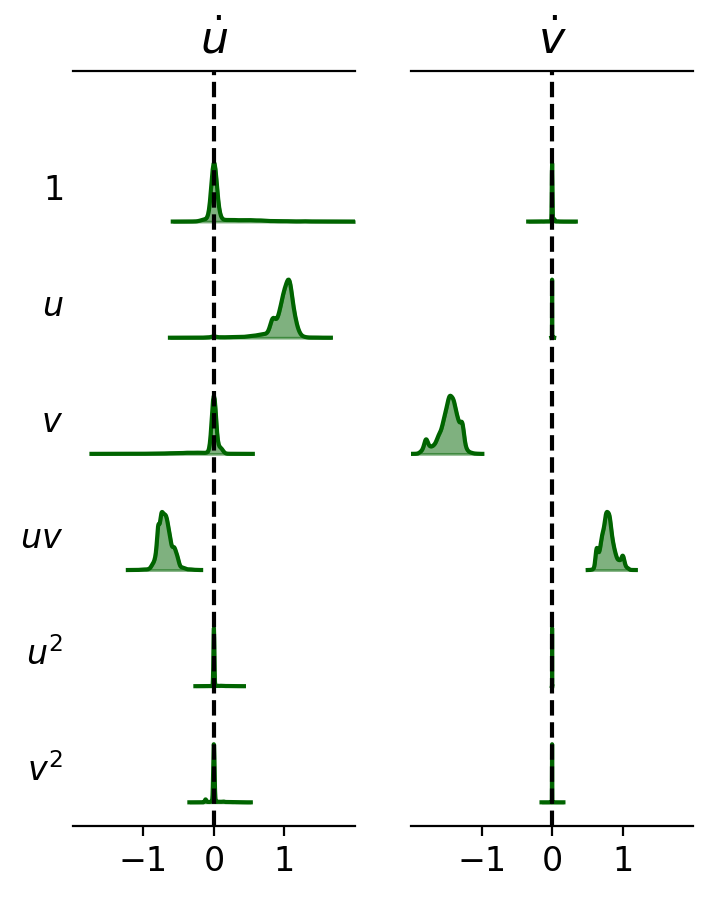

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# create some data
n = 1000
exps = (synthetic_ss_12param['pnss'].T[::2,:][[5,0,1,2,3,4][::-1],:], synthetic_ss_12param['pnss'].T[1::2,:][[5,0,1,2,3,4][::-1],:])


colors = ['darkgreen','darkgreen']

fig, ax = plt.subplots(1,2,dpi=200)
for sbplt, var in enumerate(exps):
    for i, v in enumerate(var):
        sns.kdeplot(data=v + np.random.randn(*v.shape) * 0.0002,color=colors[sbplt],ax=ax[sbplt])
       # if i==5 and sbplt==1:
       #     sns.kdeplot(data=var[-1,:],color=colors[sbplt],ax=ax[sbplt])

for r in range(2):    
# find the line and rescale y-values
    children = ax[r].get_children()
    c = 0
    for child in children:
        if isinstance(child, matplotlib.lines.Line2D):
            x, y = child.get_data()
            print(x[np.argmax(y)])
            y = y/y.max() * 0.5 + c + 0.2
            child.set_data(x,y)
            ax[r].fill_between(x,c + 0.2, y, alpha=0.5,color=colors[r])
            c+= 1
        
for i in range(2):
    ax[i].set_ylim([0,6.5])
    #ax[i].set_xlabel('Coefficient value', fontsize=14)
    ax[i].set_ylabel('')
    ax[i].set_title([r'$\dot{u}$',r'$\dot{v}$'][i % 2], fontsize=16)
    ax[i].plot([0, 0], [0, 20], 'k--')
    ax[i].set_yticks([])  
    ax[i].tick_params(axis='x', which='major', labelsize=12)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_xticks([-1,0,1])
    ax[i].set_xlim([-2,2])
    #ax[i].axis('off')
    
ax[0].set_yticks(np.arange(6) + 0.5)
#ax[0].set_yticks(np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]) * 0.85 - 0.01)
#ax[0].set_yticklabels([ r'$\dot{u} \ \colon \ u$', r'$\dot{v} \ \colon \ u$',
#                    r'$\dot{u} \ \colon \ v$', r'$\dot{v} \ \colon \ v$',
#                    r'$\dot{u} \ \colon \ u v$', r'$\dot{v} \ \colon \ u v$',
#                    r'$\dot{u} \ \colon \ u^2$', r'$\dot{v} \ \colon \ u^2$',
#                    r'$\dot{u} \ \colon \ v^2$', r'$\dot{v} \ \colon \ v^2$',
#                    r'$\dot{v} \ \colon \ 1$', r'$\dot{u} \ \colon \ 1$'][:6], fontsize=16)

ax[0].set_yticklabels([ r'$1$',
                       r'$u$', 
                    r'$v$', 
                    r'$ u v$', 
                    r'$u^2$', 
                    r'$v^2$'][::-1], fontsize=12)
ax[0].yaxis.set_tick_params(length=0)

    
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(4, 5)
plt.savefig('fig3a.pdf')

0.002768329043279505
0.0028588620210089344
-0.6663333451913653
-0.010422570575150836
0.9767139020325815
0.017533884000683786
0.0005464168156342208
0.004472022409812093
0.731607585087291
-1.389364729102068
0.0005734519311315633
-0.006515443908674312


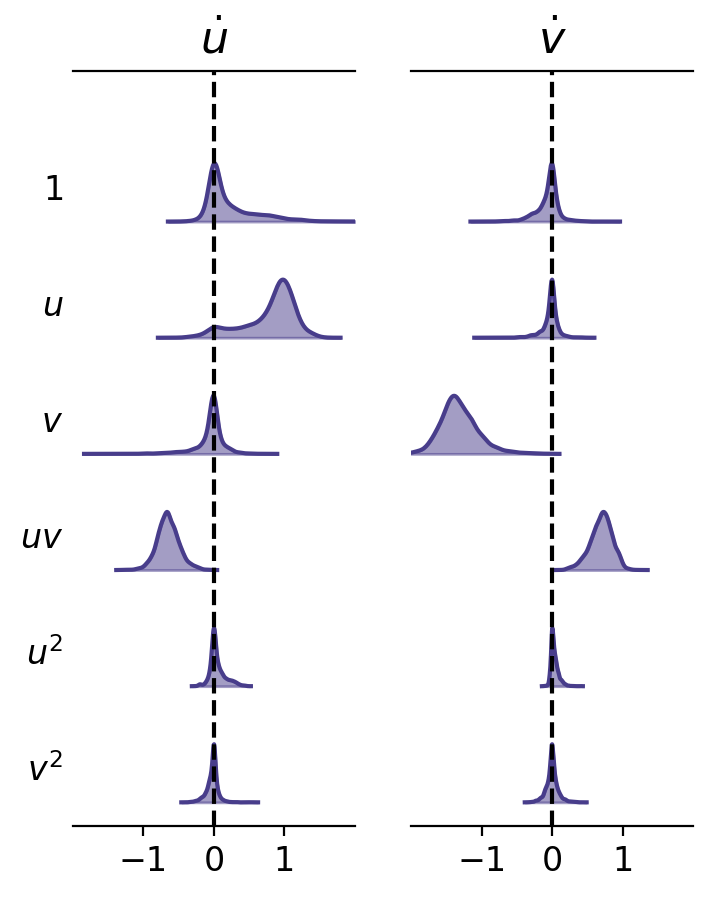

In [35]:
# import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# create some data
n = 1000
exps = (synthetic_rh_12param['pn'].T[::2,:][[5,0,1,2,3,4][::-1],:], synthetic_rh_12param['pn'].T[1::2,:][[5,0,1,2,3,4][::-1],:])


colors = ['darkslateblue','darkslateblue']

fig, ax = plt.subplots(1,2,dpi=200)
for sbplt, var in enumerate(exps):
    for i, v in enumerate(var):
        sns.kdeplot(data=v,color=colors[sbplt],ax=ax[sbplt])
        #if i==5 and sbplt==1:
        #    sns.kdeplot(data=var[-1,:],color=colors[sbplt],ax=ax[sbplt])
res_rh = []
        
        
for r in range(2):    
# find the line and rescale y-values
    children = ax[r].get_children()
    c = 0
    for child in children:
        if isinstance(child, matplotlib.lines.Line2D):
            x, y = child.get_data()
            print(x[np.argmax(y)])
            res_rh.append(x[np.argmax(y)])
            y = y/y.max() * 0.5 + c + 0.2
            child.set_data(x,y)
            ax[r].fill_between(x,c + 0.2, y, alpha=0.5,color=colors[r])
            c+= 1
        
for i in range(2):
    ax[i].set_ylim([0,6.5])
    #ax[i].set_xlabel('Coefficient value', fontsize=14)
    ax[i].set_ylabel('')
    ax[i].set_title([r'$\dot{u}$',r'$\dot{v}$'][i % 2], fontsize=16)
    ax[i].plot([0, 0], [0, 20], 'k--')
    ax[i].set_yticks([])  
    ax[i].tick_params(axis='x', which='major', labelsize=12)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_xticks([-1,0,1])
    ax[i].set_xlim([-2,2])
    #ax[i].axis('off')
    
ax[0].set_yticks(np.arange(6) + 0.5)
#ax[0].set_yticks(np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]) * 0.85 - 0.01)
#ax[0].set_yticklabels([ r'$\dot{u} \ \colon \ u$', r'$\dot{v} \ \colon \ u$',
#                    r'$\dot{u} \ \colon \ v$', r'$\dot{v} \ \colon \ v$',
#                    r'$\dot{u} \ \colon \ u v$', r'$\dot{v} \ \colon \ u v$',
#                    r'$\dot{u} \ \colon \ u^2$', r'$\dot{v} \ \colon \ u^2$',
#                    r'$\dot{u} \ \colon \ v^2$', r'$\dot{v} \ \colon \ v^2$',
#                    r'$\dot{v} \ \colon \ 1$', r'$\dot{u} \ \colon \ 1$'][:6], fontsize=16)

ax[0].set_yticklabels([r'$1$',r'$u$', 
                    r'$v$', 
                    r'$ u v$', 
                    r'$u^2$', 
                    r'$v^2$'][::-1], fontsize=12)
ax[0].yaxis.set_tick_params(length=0)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(4, 5)
plt.savefig('fig3b.pdf')

In [11]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas
import sunode.wrappers.as_theano as sun


## Generate Data
from scipy.integrate import ode
alpha  = 1
beta=0.1
gamma=1.5
delta=0.75 * 0.1
def dX_dt(t, state,par):
    """ Return the growth rate of fox and rabbit populations. """
    alpha,beta,gamma,delta = par
    return np.array([ alpha*state[0] -   beta*state[0]*state[1],
                  -gamma*state[1] + delta*state[0]*state[1]])

t = np.linspace(0, 24,  50)              # time
X0 = np.array([10, 5])                    # initials conditions: 10 rabbits and 5 foxes
r = ode(dX_dt).set_integrator('dopri5')
r.set_initial_value(X0, t[0])
r.set_f_params((alpha,beta,gamma,delta))
X = np.zeros((len(X0),len(t)))
X[:,0] = X0
for i, _t in enumerate(t):
    if i == 0:
        continue
    r.integrate(_t)
    X[:, i] = r.y

np.random.seed(0)
yobs = X.T * np.random.lognormal(mean=0,sigma=0.1,size=X.T.shape)  #np.maximum(X.T + 2*np.random.randn(*X.T.shape),1)
times = t
print(yobs.std(axis=0))
yobs_norm = yobs / yobs.std(axis=0)



## Do Bayesian Sindy
def predator_prey_sunode_library(t, y, p):
    du_dt = p.pn[0] * y.u + p.pn[2] * y.v + p.pn[4] * y.u * y.v + p.pn[6] * y.u**2 + p.pn[8]* y.v**2 + p.pn[10] - 1e-5 * y.u**3
    dv_dt = p.pn[1] * y.u + p.pn[3] * y.v + p.pn[5] * y.u * y.v + p.pn[7] * y.u**2 + p.pn[9]*y.v**2 + p.pn[11] - 1e-5 * y.v**3
    return {'u': du_dt, 'v' : dv_dt}


d = 12

model_sunode = pm.Model()

with model_sunode:

    sigma = pm.Lognormal('sigma', mu=-1, sigma=0.1, shape=2)
    pn = pm.Normal('pn', mu=0, sigma=1, shape=d)
    y0 = pm.Lognormal('y0', mu=pm.math.log(1), sigma=1, shape=2)

    y_hat, _, problem, solver, _, _ = sun.solve_ivp(
        
        y0={
            'u': (y0[0], ()),
            'v': (y0[1], ()),
            },
            params={
                'pn' : (pn,d),
                'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
            },
            rhs=predator_prey_sunode_library,
            make_solver='RK45',
            tvals=times,
            t0=times[0],
        )


    import sunode
    lib = sunode._cvodes.lib
    lib.CVodeSetMaxNumSteps(solver._ode, 1200)
    lib.CVodeSetMaxNumStepsB(solver._ode, solver._odeB, 1200)
    lib.CVodeSStolerances(solver._ode, 1e-6, 1e-6)
    lib.CVodeSStolerancesB(solver._ode, solver._odeB, 1e-6, 1e-6)
    lib.CVodeQuadSStolerancesB(solver._ode, solver._odeB, 1e-6, 1e-6)

    uobs = pm.Lognormal('uobs', mu=pm.math.log(y_hat['u'][:]), sigma=sigma[0], observed=yobs_norm[:,0])
    vobs = pm.Lognormal('vobs', mu=pm.math.log(y_hat['v'][:]), sigma=sigma[1], observed=yobs_norm[:,1])

with model_sunode:

    start = pm.find_MAP()

    # Initialize parameters with least squares and all other values with MAP
    inp = yobs_norm
    u = inp[:,0]
    v = inp[:,1]

    θ = np.array([u,v,u*v,u**2,v**2,np.ones(u.shape)]).T

    import pysindy as ps
    from pysindy.differentiation import SmoothedFiniteDifference
    sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
    dx = sfd(inp)

    guess = np.linalg.lstsq(θ,dx)[0]
    
    print('Initialization')
    print(guess)

    start['pn'] = guess.flatten()
    start['pnss'] = start['pn']
    start['xi'] = np.ones(start['pn'].shape).astype(int)
    start['y0'] = yobs_norm[0,:]
    start['y0_log__'] = np.log(start['y0'])

    #trace = pm.sample(4000, tune=2000, cores=2, start=start,random_seed=0,target_accept=0.95)
    synthetic_gauss = pm.backends.load_trace('../synthetic_gauss_12param' + '.trace',model_sunode)

[10.94487607  6.80885278]


logp = nan, ||grad|| = 0: 100%|██████████| 62/62 [00:00<00:00, 270.20it/s]            
/home/hirshs/anaconda3/envs/mars-sunode/lib/python3.7/site-packages/ipykernel_launcher.py:103: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Initialization
[[-0.00799787  0.08987216]
 [-0.75074696 -0.5146038 ]
 [-0.12253869  0.21118045]
 [ 0.050315    0.02684945]
 [ 0.12290753  0.0284561 ]
 [ 0.84539028 -0.19105767]]


0.8833851420891086
0.28874257490891253
-0.384658870936917
-0.5677907823945103
0.16350579111630154
0.07717608805361609
0.12889951260893717
-0.3813880217070993
-1.347664183063951
0.6236410234276233
0.1142039984398362
-0.02889410846539031


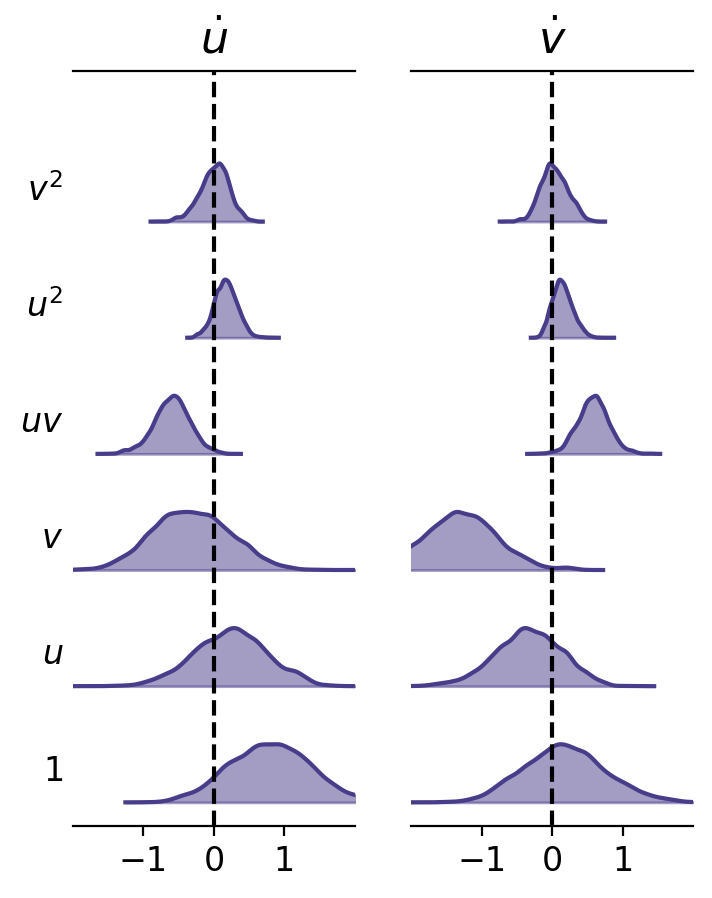

In [12]:
# import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# create some data
n = 1000
exps = (synthetic_gauss['pn'].T[::2,:][[5,0,1,2,3,4],:], synthetic_gauss['pn'].T[1::2,:][[5,0,1,2,3,4],:])


colors = ['darkslateblue','darkslateblue']

fig, ax = plt.subplots(1,2,dpi=200)
for sbplt, var in enumerate(exps):
    for i, v in enumerate(var):
        sns.kdeplot(data=v,color=colors[sbplt],ax=ax[sbplt])
        #if i==5 and sbplt==1:
        #    sns.kdeplot(data=var[-1,:],color=colors[sbplt],ax=ax[sbplt])

res_gauss = []
for r in range(2):    
# find the line and rescale y-values
    children = ax[r].get_children()
    c = 0
    for child in children:
        if isinstance(child, matplotlib.lines.Line2D):
            x, y = child.get_data()
            print(x[np.argmax(y)])
            res_gauss.append(x[np.argmax(y)])
            y = y/y.max() * 0.5 + c + 0.2
            child.set_data(x,y)
            ax[r].fill_between(x,c + 0.2, y, alpha=0.5,color=colors[r])
            c+= 1
        
for i in range(2):
    ax[i].set_ylim([0,6.5])
    #ax[i].set_xlabel('Coefficient value', fontsize=14)
    ax[i].set_ylabel('')
    ax[i].set_title([r'$\dot{u}$',r'$\dot{v}$'][i % 2], fontsize=16)
    ax[i].plot([0, 0], [0, 20], 'k--')
    ax[i].set_yticks([])  
    ax[i].tick_params(axis='x', which='major', labelsize=12)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_xticks([-1,0,1])
    ax[i].set_xlim([-2,2])
    #ax[i].axis('off')
    
ax[0].set_yticks(np.arange(6) + 0.5)
#ax[0].set_yticks(np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]) * 0.85 - 0.01)
#ax[0].set_yticklabels([ r'$\dot{u} \ \colon \ u$', r'$\dot{v} \ \colon \ u$',
#                    r'$\dot{u} \ \colon \ v$', r'$\dot{v} \ \colon \ v$',
#                    r'$\dot{u} \ \colon \ u v$', r'$\dot{v} \ \colon \ u v$',
#                    r'$\dot{u} \ \colon \ u^2$', r'$\dot{v} \ \colon \ u^2$',
#                    r'$\dot{u} \ \colon \ v^2$', r'$\dot{v} \ \colon \ v^2$',
#                    r'$\dot{v} \ \colon \ 1$', r'$\dot{u} \ \colon \ 1$'][:6], fontsize=16)

ax[0].set_yticklabels([ r'$1$',r'$u$', 
                    r'$v$', 
                    r'$ u v$', 
                    r'$u^2$', 
                    r'$v^2$'], fontsize=12)
ax[0].yaxis.set_tick_params(length=0)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(4, 5)
plt.show()

In [13]:
# Shrinkage coefficients regularized horseshoe
np.reshape(np.array(res_rh) / np.array(res_gauss),(6,2),order='F')[::-1,:]

array([[ 3.58702950e-02, -1.89110114e-02],
       [ 1.74847753e-02,  3.91581947e-02],
       [ 1.17355435e+00,  1.17312293e+00],
       [ 2.70956199e-02,  1.03094283e+00],
       [ 3.38264595e+00, -1.50359188e-03],
       [ 1.98485159e-02, -5.05466916e-02]])

In [14]:
# Inclusion probablities spike and slab
np.reshape(synthetic_ss_12param['pnss'].mean(axis=0),(6,2))[[-1,0,1,2,3,4],:][::-1,:]

array([[ 2.91385875e-03, -1.37621983e-04],
       [ 7.70010116e-03, -7.55675169e-06],
       [-6.89873922e-01,  7.96633410e-01],
       [-4.59669232e-02, -1.46367047e+00],
       [ 9.72750017e-01,  1.17162554e-03],
       [ 7.71654355e-02,  5.71724050e-04]])

In [15]:
# Apply sindy to data
import pysindy as ps
from pysindy.differentiation import SmoothedFiniteDifference
sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
#dx = sfd(inp)
data = yobs
dx = sfd(data)
optimizer = ps.STLSQ(threshold=0.04)
feature_library = ps.PolynomialLibrary(degree=2)
model = ps.SINDy(feature_names=["x", "y"],optimizer=optimizer,feature_library=feature_library)
model.fit(data, t=times)
sim = model.simulate(data[0], np.hstack((times)),hmin=1e-8)
model.print()

x' = 6.781 1 + 0.535 x + -0.786 y + -0.047 x y
y' = -1.932 1 + 0.125 x + -1.157 y + 0.055 x y


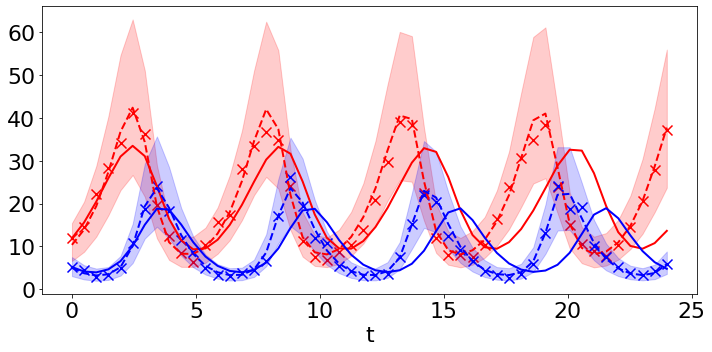

In [54]:
plt.figure(figsize=(10,5))
ax = plt.subplot(1,1,1)
name = ['uobs','vobs']
colors = ['r','b']
for i in range(2):
    series = ppc_ss[name[i]].T * yobs.std(axis=0)[i]
    
    #for j in range(1,100):
    #    a,b = 0.05*j,100-0.05*j
    #    above = np.percentile(series,a,axis=1)
    #    below = np.percentile(series,b,axis=1)
    #    plt.fill_between(times, below, above, color=colors[i], alpha=0.004)
    
    a,b = 5,95
    above = np.percentile(series,a,axis=1)
    below = np.percentile(series,b,axis=1)
    plt.fill_between(times, below, above, color=colors[i], alpha=0.2,label='a')
    
    #plt.plot(times,sim[:, i], "-", color=colors[i],label='b', linewidth=2)
    #plt.plot(times,sim[:, 1], "-", color='blue',label="SINDy model", linewidth=2)
    mu = series.mean(axis=1)
    plt.plot(times, mu, '--', color=colors[i], lw=2, label='c');
    plt.plot(times,sim[:, i], "-", color=colors[i],label='b', linewidth=2)
    #plt.plot(times,sim[:, 0]*np.std(yobs,axis=0)[0], "-.", color='red',alpha=0.15,label="SINDy model", linewidth=3)
    #plt.plot(times,sim[:, 1]*np.std(yobs,axis=0)[1], "-.", color='blue',alpha=0.15,label="SINDy model", linewidth=3)
    #plt.fill_between(times, below, above, color=colors[i], alpha=0.3)
    plt.scatter(times, yobs[:,i], color=colors[i],marker='x',s=100, alpha=1.0, label='d');
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    #plt.legend(ncol=4,title='   ')
    name = ['uobs','vobs']
    colors = ['r','b']

    #handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    #labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    #ax.legend(handles, labels,ncol=4)

    
    plt.xlabel('t',fontsize=22)
    #plt.ylabel('Population',fontsize=22)
    plt.tight_layout()
    plt.savefig('fig3c.pdf')
    #plt.savefig('legend.pdf')

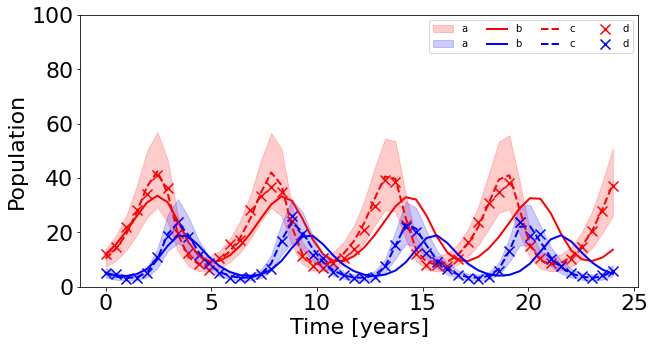

In [32]:
plt.figure(figsize=(10,5))
ax = plt.subplot(1,1,1)
name = ['uobs','vobs']
colors = ['r','b']
for i in range(2):
    series = ppc_ss[name[i]].T * yobs.std(axis=0)[i]
    
    #for j in range(1,100):
    #    a,b = 0.05*j,100-0.05*j
    #    above = np.percentile(series,a,axis=1)
    #    below = np.percentile(series,b,axis=1)
    #    plt.fill_between(times, below, above, color=colors[i], alpha=0.004)
    
    a,b = 10,90
    above = np.percentile(series,a,axis=1)
    below = np.percentile(series,b,axis=1)
    plt.fill_between(times, below, above, color=colors[i], alpha=0.2,label='a')
    
    plt.plot(times,sim[:, i], "-", color=colors[i],label='b', linewidth=2)
    #plt.plot(times,sim[:, 1], "-", color='blue',label="SINDy model", linewidth=2)
    mu = series.mean(axis=1)
    plt.plot(times, mu, '--', color=colors[i], lw=2, label='c');
    #plt.plot(times,sim[:, 0]*np.std(yobs,axis=0)[0], "-.", color='red',alpha=0.15,label="SINDy model", linewidth=3)
    #plt.plot(times,sim[:, 1]*np.std(yobs,axis=0)[1], "-.", color='blue',alpha=0.15,label="SINDy model", linewidth=3)
    #plt.fill_between(times, below, above, color=colors[i], alpha=0.3)
    plt.scatter(times, yobs[:,i], color=colors[i],marker='x',s=100, alpha=1.0, label='d');
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    #plt.legend(ncol=4,title='   ')
    plt.ylim(0,100)
    name = ['uobs','vobs']
    colors = ['r','b']

    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels,ncol=4)

    
    plt.xlabel('Time [years]',fontsize=22)
    plt.ylabel('Population',fontsize=22)
    plt.savefig('legend.pdf')

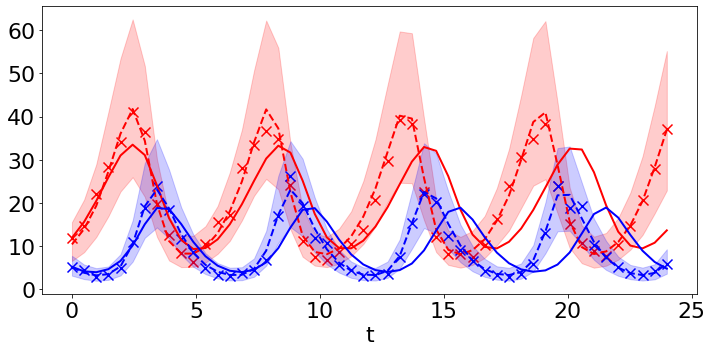

In [53]:
plt.figure(figsize=(10,5))
name = ['uobs','vobs']
colors = ['r','b']
for i in range(2):
    series = ppc_rh[name[i]].T * yobs.std(axis=0)[i]
    
    #for j in range(1,100):
    #    a,b = 0.05*j,100-0.05*j
    #    above = np.percentile(series,a,axis=1)
    #    below = np.percentile(series,b,axis=1)
    #    plt.fill_between(times, below, above, color=colors[i], alpha=0.004)
    
    a,b = 5,95
    above = np.percentile(series,a,axis=1)
    below = np.percentile(series,b,axis=1)
    plt.fill_between(times, below, above, color=colors[i], alpha=0.2)
    
    #plt.plot(times,sim[:, 0], "-", color='red',label="SINDy model", linewidth=2)
    #plt.plot(times,sim[:, 1], "-", color='blue',label="SINDy model", linewidth=2)
    mu = series.mean(axis=1)
    plt.plot(times, mu, '--', color=colors[i], lw=2, label="mean");
    plt.plot(times,sim[:, i], "-", color=colors[i],label='b', linewidth=2)
    #plt.plot(times,sim[:, 0]*np.std(yobs,axis=0)[0], "-.", color='red',alpha=0.15,label="SINDy model", linewidth=3)
    #plt.plot(times,sim[:, 1]*np.std(yobs,axis=0)[1], "-.", color='blue',alpha=0.15,label="SINDy model", linewidth=3)
    #plt.fill_between(times, below, above, color=colors[i], alpha=0.3)
    plt.scatter(times, yobs[:,i], color=colors[i],marker='x',s=100, alpha=1.0, label="observed data");
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.xlabel('t',fontsize=22)
    plt.tight_layout()
    plt.savefig('fig3d.pdf')
    #plt.ylabel('Population',fontsize=22)

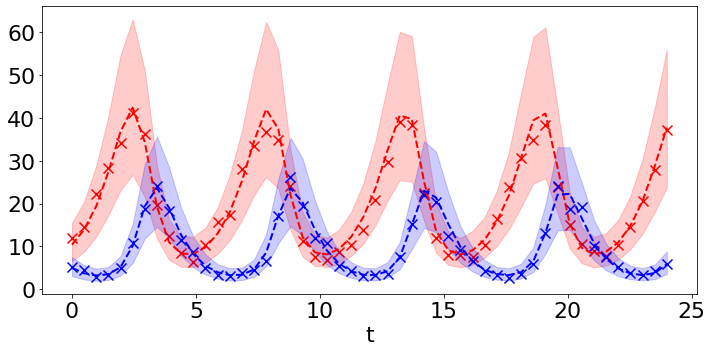

In [56]:
plt.figure(figsize=(10,5))
ax = plt.subplot(1,1,1)
name = ['uobs','vobs']
colors = ['r','b']
for i in range(2):
    series = ppc_ss[name[i]].T * yobs.std(axis=0)[i]
    
    #for j in range(1,100):
    #    a,b = 0.05*j,100-0.05*j
    #    above = np.percentile(series,a,axis=1)
    #    below = np.percentile(series,b,axis=1)
    #    plt.fill_between(times, below, above, color=colors[i], alpha=0.004)
    
    a,b = 5,95
    above = np.percentile(series,a,axis=1)
    below = np.percentile(series,b,axis=1)
    plt.fill_between(times, below, above, color=colors[i], alpha=0.2,label='a')
    
    #plt.plot(times,sim[:, i], "-", color=colors[i],label='b', linewidth=2)
    #plt.plot(times,sim[:, 1], "-", color='blue',label="SINDy model", linewidth=2)
    mu = series.mean(axis=1)
    plt.plot(times, mu, '--', color=colors[i], lw=2, label='c');
    #plt.plot(times,sim[:, i], "-", color=colors[i],label='b', linewidth=2)
    #plt.plot(times,sim[:, 0]*np.std(yobs,axis=0)[0], "-.", color='red',alpha=0.15,label="SINDy model", linewidth=3)
    #plt.plot(times,sim[:, 1]*np.std(yobs,axis=0)[1], "-.", color='blue',alpha=0.15,label="SINDy model", linewidth=3)
    #plt.fill_between(times, below, above, color=colors[i], alpha=0.3)
    plt.scatter(times, yobs[:,i], color=colors[i],marker='x',s=100, alpha=1.0, label='d');
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    #plt.legend(ncol=4,title='   ')
    name = ['uobs','vobs']
    colors = ['r','b']

    #handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    #labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    #ax.legend(handles, labels,ncol=4)

    
    plt.xlabel('t',fontsize=22)
    #plt.ylabel('Population',fontsize=22)
    plt.tight_layout()
    plt.savefig('fig3c_without_sindy.pdf')
    #plt.savefig('legend.pdf')